In [220]:
#pymongo DB
from pymongo import MongoClient
import os
import json

#import pandas pyplot
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
#from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import numpy as np

In [221]:
client = MongoClient(port=27017)
client = MongoClient("mongodb://localhost:27017/")
mydb = client["MemeStock"]

In [222]:
def CreateDataframeFromMongoDB(database,collection):
    mycollection = database[collection]
    allrecord = mycollection.find()
    df = pd.DataFrame(list(allrecord))
    return(df)

In [223]:
SPY_hourly_df = CreateDataframeFromMongoDB(mydb,"table_spystock")
Tweet_TSLA_hourly_df = CreateDataframeFromMongoDB(mydb,"table_TSLA")
TSLA_hourly_df = CreateDataframeFromMongoDB(mydb,"table_tslastock")

In [224]:
# condense DFs to only columns that will be require 
TSLA_hourly_df=TSLA_hourly_df[["date_UTC","Percent_Day_Change","Volume"]]
Tweet_TSLA_hourly_df=Tweet_TSLA_hourly_df[["date_UTC","tweet_counts"]]
SPY_hourly_df=SPY_hourly_df[["date_UTC","Percent_Day_Change","Volume"]]

In [225]:
#rename Columns
TSLA_hourly_df= TSLA_hourly_df.rename(columns={'Percent_Day_Change': 'Percent_Day_Change_TSLA', 'Volume': 'Volume_TSLA'})
SPY_hourly_df=SPY_hourly_df.rename(columns={'Percent_Day_Change': 'Percent_Day_Change_SPY', 'Volume': 'Volume_SPY'})
#make all DFs match d type for date_UTC
TSLA_hourly_df['date_UTC']=TSLA_hourly_df['date_UTC'].astype({'date_UTC': 'datetime64[ns]'})
SPY_hourly_df['date_UTC']=SPY_hourly_df['date_UTC'].astype({'date_UTC': 'datetime64[ns]'})
Tweet_TSLA_hourly_df['date_UTC']=Tweet_TSLA_hourly_df['date_UTC'].astype({'date_UTC': 'datetime64[ns]'})

In [226]:
#create the 3 combine df to one DF, encoded our Y value
combined_all_df=TSLA_hourly_df.merge(SPY_hourly_df, how='left', on="date_UTC")
combined_all_df=combined_all_df.merge(Tweet_TSLA_hourly_df, how='left', on="date_UTC")
combined_all_df=combined_all_df.dropna(axis=0, how='any')

In [227]:
#create new DFs to for more analysis
TSLA_Tweet_df=combined_all_df[["Percent_Day_Change_TSLA","tweet_counts"]]
TSLA_SPY_df=combined_all_df[["Percent_Day_Change_TSLA","Percent_Day_Change_SPY"]]
TSLA_Volume_df=combined_all_df[["Percent_Day_Change_TSLA","Volume_TSLA"]]
#TSLA_Volume_df=combined_all_df[["Percent_Day_Change_TSLA","Volume_TSLA","tweet_counts"]]

In [228]:
combined_all_df.to_csv("resources/combined_all_df.csv")
#combined_all_df_encode.to_csv("resources/combined_all_df_encode.csv")

In [229]:
#creates a plot of a 1 attribute (x) DB 
def linear_reg_model_basic(df):
    df_x=df.drop(["Percent_Day_Change_TSLA"], axis=1)
    df_lenght=df_x.columns.size
    X = df_x.values.reshape(-1,df_lenght)
    y=df["Percent_Day_Change_TSLA"]
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    r2_score=model.score(X,y)
    coef=model.coef_
    ax = plt.subplot()
    plt.scatter(X, y)
    plt.plot(X, y_pred, color='red')
    plt.xlabel(df_x.columns.tolist())
    plt.ylabel("Percent_Change_TSLA")
    plt.text(1, 1, f'r2_score: {r2_score:.6f}\n coef={coef}', horizontalalignment='right',
         verticalalignment='top',transform= ax.transAxes)
    plt.savefig(f'resources/{df_x.columns.tolist()[0]}_fig.png')
    return plt.show()

In [241]:
#creates a plot of a multi attributes(x) DB 
def linear_reg_model_multi(df):
    df_x=df.drop(["Percent_Day_Change_TSLA","date_UTC","date_UTC"], axis=1)
    df_lenght=df_x.columns.size
    X = df_x.values.reshape(-1,df_lenght)
    y=df["Percent_Day_Change_TSLA"]
    model = LinearRegression()
    model.fit(X, y)
    #r2_score=model.score(X,y)
    coef=model.coef_
    allcoef_df=pd.DataFrame(coef, index=df_x.columns.tolist(), columns=["Coefficient"])
    allcoef_df.to_csv("resources/allcoef.csv")
    
    #upload to mangodb 
    data=allcoef_df.to_json(orient='records')
    mytable = mydb["Linear_Reg_Coeff"]
    mytable = mytable.drop()
    mytable = mydb["Linear_Reg_Coeff"]
    mytable.insert(data)
    
    return allcoef_df

In [242]:
#creates a plot of a multi attributes(x) DB 
def linear_reg_model_multi_rscore(df):
    df_x=df.drop(["Percent_Day_Change_TSLA","date_UTC","date_UTC"], axis=1)
    df_lenght=df_x.columns.size
    X = df_x.values.reshape(-1,df_lenght)
    y=df["Percent_Day_Change_TSLA"]
    model = LinearRegression()
    model.fit(X, y)
    r2_score=model.score(X,y)
    #coef=model.coef_
    #allcoef_df=pd.DataFrame(coef, index=df_x.columns.tolist(), columns=["Coefficient"])
    r2_df=pd.Series(r2_score, index= ["Rsquare_score"], name= "Rsquare_score")
    r2_df.to_csv('resources/r2_score.csv')
    
    #upload to mangodb 
    data=allcoef_df.to_dict("records")
    mytable = mydb["Linear_Reg_Coeff"]
    mytable = mytable.drop()
    mytable = mydb["Linear_Reg_Coeff"]
    mytable.insert(data)
    
    return r2_df

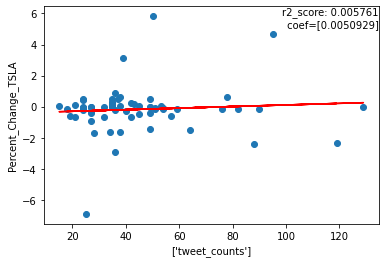

In [205]:
linear_reg_model_basic(TSLA_Tweet_df)

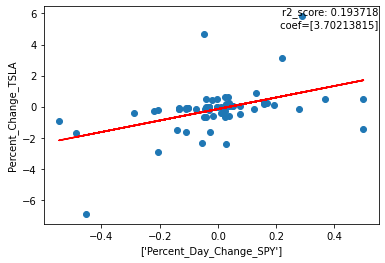

In [206]:
linear_reg_model_basic(TSLA_SPY_df)

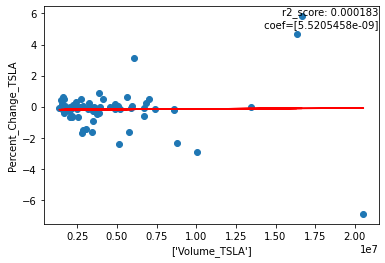

In [207]:
linear_reg_model_basic(TSLA_Volume_df)

In [234]:
linear_reg_model_multi(combined_all_df)

,Coefficient
Volume_TSLA,1.451322e-08
Percent_Day_Change_SPY,3.709576e+00
Volume_SPY,5.407689e-09
tweet_counts,2.045426e-03


In [219]:
linear_reg_model_multi_rscore(combined_all_df)

Rsquare_score    0.197003
Name: Rsquare_score, dtype: float64